In [23]:
from ieeg.auth import Session
from IPython.display import Image

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from scipy import signal as sig
import math

In [24]:
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skew, kurtosis

# Docs: https://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn.feature_extraction import DictVectorizer

In [25]:
colors = ["#cec5c1", "#9f8f7f", "#924a42", "#5a2028",
        "#a4b9b1", "#4ea7a6", "#026d73", "#06494f"];

plt.rcParams['savefig.dpi'] = 300;

rc('font', **{'family':'serif', 'serif':['Computer Modern']})
rc('text', usetex = True)

In [26]:
with open('jrp_ieeglogin.bin', 'r') as f:
  session = Session('jrp24', f.read()); 

dataset = session.open_dataset('I521_Sub1_Training_ecog'); 

print(dataset.get_channel_indices); 

<bound method Dataset.get_channel_indices of Dataset with: 62 channels.>


In [27]:
# Provided in class
def load_full_channels(dataset, duration_secs, sampling_rate, chn_idx):

  chn_segments = []; 
  num_segments = int(np.ceil(duration_secs * sampling_rate / 6e5)); 
  seg_start, step = np.linspace(1, duration_secs * 1e6, num_segments, endpoint = False, retstep = True); 

  for start in seg_start:
    chn_segments.append(dataset.get_data(start, step, chn_idx)); 

  return np.vstack(chn_segments); 


In [28]:
duration_us = dataset.end_time - dataset.start_time; # in microseconds
duration_s = duration_us * 1e-6; # in seconds
duration_min = duration_s / 60; 
duration_hr = duration_min / 60; 
duration_ms = duration_us * 1e-3; 

period = 0.001; 
frequency = 1 / period 

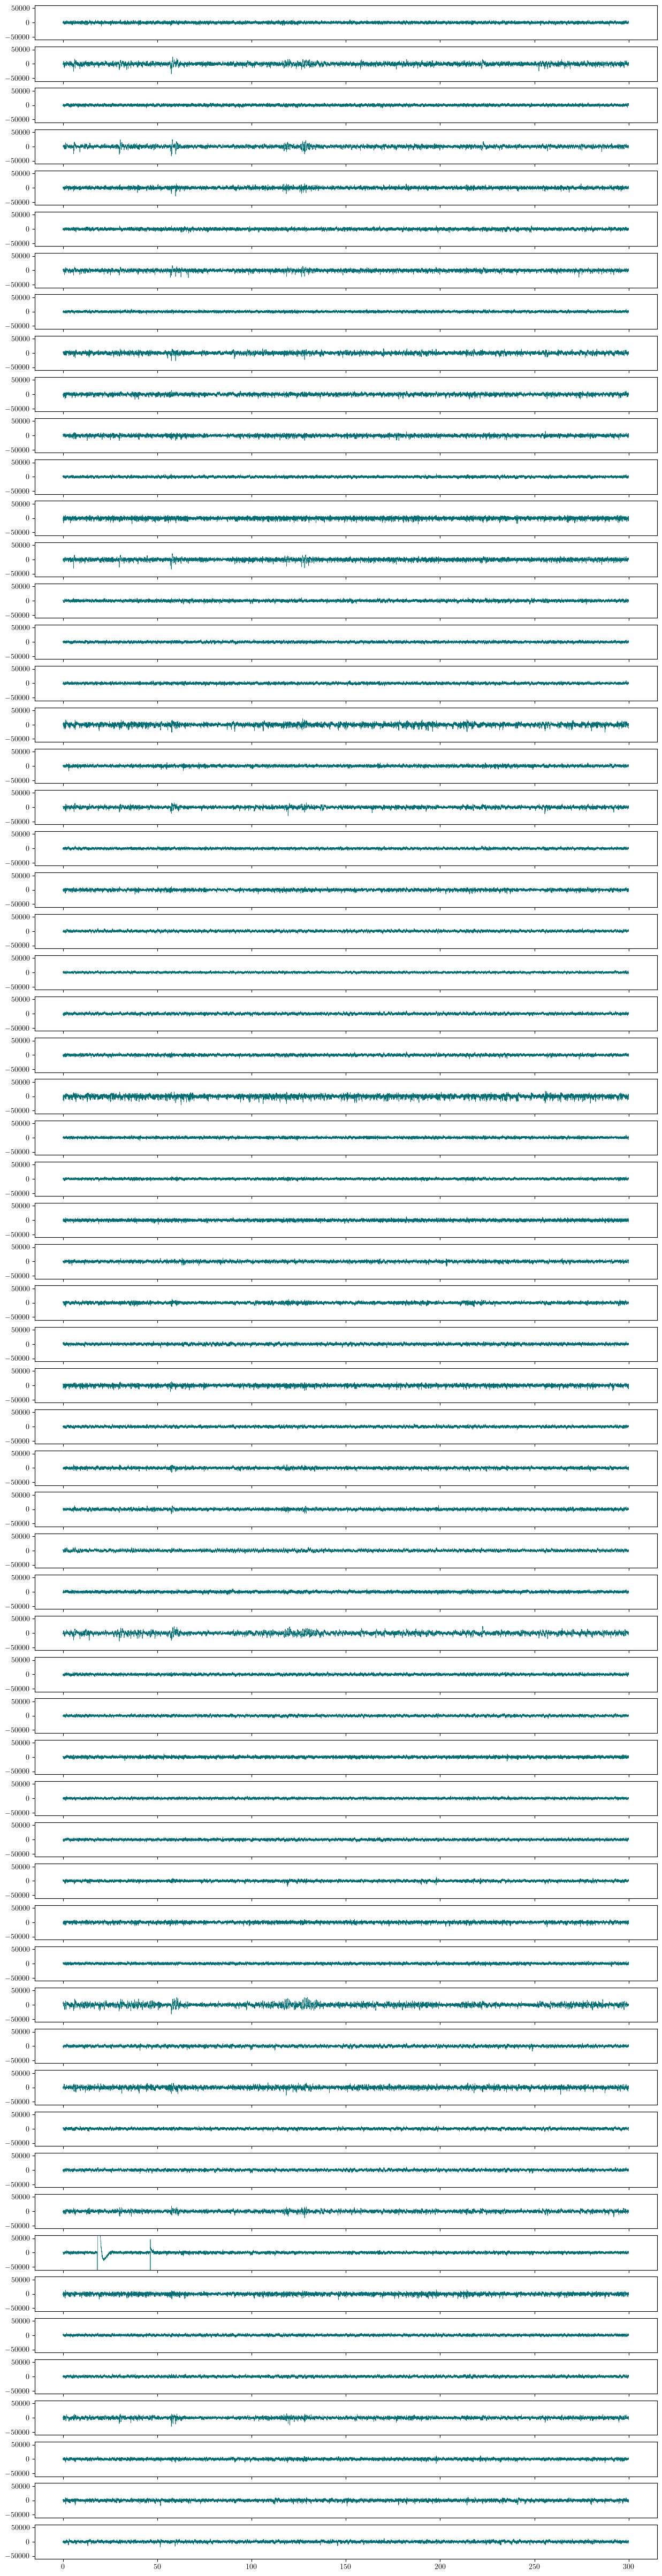

In [29]:
num_channels = 62; 
fig, axs = plt.subplots(num_channels, 1, sharex = True); 

fig.set_figwidth(15); 
fig.set_figheight(62); 

for i in range(62):
    signal = load_full_channels(dataset, duration_s, frequency, [i]);
    x_axis = np.linspace(0, len(signal), len(signal)) / frequency;

    axs[i].plot(x_axis, signal, color = colors[6], linewidth = 0.5);

    axs[i].set_ylim(-60000, 60000); 

plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = None); 
plt.show(); 

In [30]:
def find_line_length(signal):

  line_length = 0;
  for i in range(1, len(signal), 1):
    line_length += abs(signal[i - 1] - signal[i])

  return float(line_length);

In [31]:
def find_area(signal):
  sum = np.sum(signal);
  # normalized_sum = sum / (len(signal) / sampling_rate); # normalized to seconds
  return float(sum);

In [32]:
def find_energy(signal):
  signal = np.square(signal)
  sum = np.sum(signal);
  # normalized_sum = sum / (len(signal) / sampling_rate); # normalized to seconds
  return float(sum);

In [33]:
def find_zero_crossing(signal):
  mean = np.mean(signal);

  zero_crossings = 0;
  for i in range(0, len(signal) - 1, 1):
    if signal[i] > mean and signal[i + 1] < mean:
      zero_crossings += 1;
    elif signal[i] < mean and signal[i + 1] > mean:
      zero_crossings += 1;

  return float(zero_crossings);

In [34]:
# NOTE: A wiser way to do this would be to take the derivative, and calculate the period when the 
# derivative is greater than x for duration y (to mark the start time), etc. Right now we define 
# the start time by magnitude, which is technically not the beginning of the spike. Plus, it might
# be helpful for noiser data (i.e., right now we define by std dev above the mean, which may vary
# depending on how noisy the data is). 

def find_spikes(signal, sampling_rate, std_dev):
    j = 0; # Used to index through the array
    num_spikes = 0; # Will store the number of spikes in this segment 
    while j < len(signal):
        if signal[j] > 3 * std_dev: # Begins counting when an amplitude that's 3 std dev above the mean is found
            start_pos = j; # Saves the starting time (of high amplitude)
            while signal[j] > 3 * std_dev and not j == len(signal) - 1: # Added second condition because it would break when reaching the end of the list
                j += 1; 
            stop_pos = j; # Stores the ending time (of high amplitude)
    
            duration = (stop_pos - start_pos) * (1 / sampling_rate); # Computes the duration of the high amplitude (in seconds)
            if duration > 0.05: # 50 ms currently 
                num_spikes += 1; # Counts the number of spikes that persist for more than x ms 
        j += 1; # Continues on through the list
    return num_spikes; 

In [35]:
# Note: we will likeyl want to convert this over to pwelch

def find_spectral_features(signal, sampling_rate, mean, std_dev):
    normalized_signal = (signal - mean) / std_dev

    fft_values = fft(normalized_signal); 

    N = len(signal); 
    freq_domain = np.fft.fftfreq(N, d = (1 / sampling_rate)); 
    fft_magnitude = np.abs(fft_values); 
    
    # Dominant frequency found as the highest magnitude fft value and its corresponding location in the frequency domain
    dominant_freq = freq_domain[np.argmax(fft_magnitude)]; 

    return (fft_magnitude, dominant_freq); 

In [41]:
# Features to add that are pre-built: 
    #   Docs: https://docs.scipy.org/doc/scipy/reference/stats.html
    #   Entropy, differential entropy
    #   Trimmed statistics
    #   Median absolute deviation
    #   Cumulative and relative frequency

# Features to add by user: 
# Note: some of these may not be useful---it depends on the type of data we get
    #   Spikes, polyspikes---value and number
    #   Spike and wave
    #   Sharp wave complexes
    #   Slow cortical potentials
    #   Sensorimotor rhythms
    #   P300 event-related potential
    #   Steady-state visual evoked potentials
    #   Error-related negative evoked potentials

def extract_features(signal, label, samping_rate):

    # This is used to convert the dictionary to a vector
    # Notably, there seems to be an issue where dictionary order is not preserved, which 
    # can be a bit inconvenient and confusing when trying to test data. It may be wise to
    # abandon dictionaries and store simply as vectors---which is a bit less easy to read,
    # but may prevent issues later. 
    vec = DictVectorizer(); 

    # The list of features, in a dictionary, that we will extract

    local_features_dict = {'label' : label, 
                'mean' : 0, 
                'std_dev': 0,
                'skewness' : 0,
                'kurt' : 0, 
                'linelength' : 0,
                'zerocrossings' : 0,
                'energy' : 0,
                'area' : 0,
                'numspikes' : 0,
                'dominant_freq' : 0}

    # Populating the features dictionary 

    # Note: 
    # I don't understand why / how this is happening, but every function is returning a 1 x 1 numpy array unless
    # I set the datatype manually. No clue how to fix---wasn't doing that like 15 mins ago...
    mean = np.mean(signal); 
    local_features_dict['mean'] = mean; 

    std_dev = np.std(signal); 
    local_features_dict['std_dev'] = std_dev; 

    skewness = skew(signal); 
    local_features_dict['skewness'] = skewness[0]; 
    kurt = kurtosis(signal); 
    local_features_dict['kurt'] = kurt[0]; 

    local_features_dict['linelength'] = find_line_length(signal); 
    local_features_dict['zerocrossings'] = find_zero_crossing(signal); 
    local_features_dict['energy'] = find_energy(signal);
    local_features_dict['area'] = find_area(signal);

    local_features_dict['numspikes'] = find_spikes(signal, samping_rate, std_dev)

    temp_holder, local_features_dict['dominant_freq'] = find_spectral_features(signal, samping_rate, mean, std_dev)


    features_vec = vec.fit_transform(local_features_dict).toarray(); 
    vec.get_feature_names_out()

    return features_vec, local_features_dict; 

In [40]:
def get_windows(signal, sampling_rate, window_length, window_displacement):

  window_len_index = int(window_length * sampling_rate);
  window_disp_index = int(window_displacement * sampling_rate);

  signal_duration_index = len(signal);

  num_windows = (signal_duration_index - window_len_index) // (window_disp_index) + 1;

  windows_list = np.zeros((num_windows, 2));

  start_index = 0;
  end_index = window_len_index;

  windows_list[0] = [start_index, end_index];

  i = 1;
  while end_index + window_len_index < len(signal) - 1:

    start_index += window_disp_index;
    end_index = start_index + window_len_index;

    windows_list[i] = [start_index, end_index];

    i += 1;

  return num_windows, windows_list;

In [38]:
def moving_win_feats(signal, sampling_rate, window_length, window_displacement):

  num_windows, windows_list = get_windows(signal, sampling_rate, window_length, window_displacement);

  num_features = 11; 
  feature_vector = np.zeros((num_windows, num_features));

  for i in range(0, num_windows, 1):

    feature_vector[i], dict_holder = extract_features(signal[int(windows_list[i, 0]) : int(windows_list[i, 1] + 1)], i, sampling_rate);


  return feature_vector;

In [50]:
features_matrix = []; 

for i in range(num_channels):
    signal = load_full_channels(dataset, duration_s, frequency, [i]); 
    features_matrix.append(moving_win_feats(signal, frequency, 1, 1)); 

/var/folders/rv/25_n51191438rcq9n5gyvwcm0000gn/T/ipykernel_90447/4257614591.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(line_length);


In [49]:
print(f"{len(features_matrix)} by {len(features_matrix[0])} by {len(features_matrix[0][0])}"); 

62 by 299 by 11
